In [47]:

import networkx as nx
import gym
# from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
# from IPython.display import SVG, display
import numpy as np
# import pogema
from pogema import GridConfig
# import matplotlib.pyplot as plt


# from custom_networkx import astar_path, grid_graph
# from history import History

# 0. Cкладываем матрицы агентов и препядствий (они пересеаться не будут)
# 1. Добавляем рамку по краям
# 2. Получаем координаты старта финиша
# 3. Получаем следующий шаг от А*
# 4. повторили упражнение
# 5. Завтра добавлю персонального картографа)

class Model:
    def __init__(self, history=None):
        self.agents = None
        self.actions = {tuple(GridConfig().MOVES[i]): i for i in
                        range(len(GridConfig().MOVES))}  # make a dictionary to translate coordinates of actions into id
        
        self.history = history
        # count_agents = len(self.history.maps) 
    
        # self.steps = [[0 for i in range(count_agents)]] if self.history is not None else []
        self.steps = []
        self.steps_corr = []
        self.errors = 0
        self.obs_data = []
        self.bot_8_path = []

    def act(self, obs, dones, positions_xy, targets_xy, ) -> list:
        self.obs_data.append(obs)
        # Достаем предыдущий шаг

        if self.history is not None:
            steps = self.steps[-1]  
            
            self.history.update_history([i[0] for i in obs], steps)

        
        def custom_concat_matrix(iter_, agents_one):
             # обновляем карту агента
            x, y  = self.history.curr_pos[iter_]
            # print(x, y)
            temp_maps = self.history.maps[iter_].copy()
            temp_maps[x-5:x+6, y-5:y+6] += agents_one
            print(temp_maps.shape)
            return temp_maps

        def veiw_shot_list(res, x, y):
            x, y = np.where(res[x-1:y+2,x-1:y+2] == 0)
            path = np.array([(i,j) for i, j in zip(x, y)]) - (1,1)
            steps = {
                    0: (0, 0),
                    2: (1, 0),   
                    1: (-1, 0),  
                    4: (0, 1),   
                    3: (0, -1),  
                }
            x_ = [[k for k in steps if (steps[k] == i).all()] for i in path]
            return [i for j in x_ for i in j]

        

        # Подготавливаем расширенную матрицу с окантовкой и смещенными точками старта\финиша
        a_ = []
        b_ = []
        edging_ = []
        for ind, i in enumerate(obs):
            pos_i_temp, pos_j_temp = np.where(i[2] == 1)
            a_temp = (int(i.shape[1]/2)+1,int(i.shape[1]/2)+1)

            # if not 0 in [z for z in i[0][...,0]]:
            #     edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0)[...,2:]
            #     a_temp = (a_temp[0], a_temp[1]-2)

            # elif not 0 in [z for z in i[0][...,-1]]:
            #     edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0)[...,:-2]

            # elif not 0 in [z for z in i[0][0,]]:
            #     edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0)[2:]
            #     a_temp = (a_temp[0]-2, a_temp[1])

            # elif not 0 in [z for z in i[0][-1,]]:
            #     edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0)[:-2]

            # else:
            edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0) #custom_concat_matrix(ind, i[1])
            edging_.append(edging_temp)
            a_.append(a_temp)
            b_.append((pos_i_temp[0]+1, pos_j_temp[0]+1))

    
        # основной код - генерим граф делаем поиск А*
        next_step = []
        k = 0
        for edging, a, b in zip(edging_, a_, b_):
            G = nx.grid_graph(edging.shape)
            # G = grid_graph(edging.shape)
            x, y = np.where(edging ==1) 
            for i, j in zip(x,y):
                if (i,j) != a and (i,j) != b:
                    try:
                        G.remove_node((i,j))
                    except:...
                        # print('error', i, j)

            if edging[6,6] == 1:
                try:
                    path_ = nx.astar_path(G, a, b)
                    if k == 8:
                        self.bot_8_path.append(path_)
                    path = np.array(path_[1]) - a
                    steps = {
                        0: (0, 0),
                        2: (1, 0),   
                        1: (-1, 0),  
                        4: (0, 1),   
                        3: (0, -1),  
                    }
                    # nx.draw(G,)
                    next_step.append([k for k in steps if (steps[k] == path).all()][0])
                except:
                    self.errors +=1
                    # исправить на действие доступное в области видимости
                    print('AAAAAAuhhh    a = ', a)
                    true_step = veiw_shot_list(edging, 6, 6)
                    # v = [1 for i in range(len(true_step))]
                    # v_ = np.exp(v)/np.sum(np.exp(v))
                    next_step.append(np.random.choice(true_step)) 
            else:
                next_step.append(0)
        # проверка на пропуск хода
        for ind, i in enumerate([i[1] for i in obs]):
            if (i[4,4] == 1 or i[5,6] == 1 or i[4,5] == 1 or i[4,6] == 1 or i[6,6] == 1) and  i[5,5] == 1:
                print('стоим на месте')
                next_step[ind] = 0
                path = (0,0)

        # Проверка на зацикленность
        try:
            # по агентам
            for ind, i in enumerate(range(len(obs))):
                history_path = [j[i] for j in self.steps[-4:]]
                x_ = np.unique(history_path[::2])
                x_1 = np.unique(history_path[1::2])
                if len(x_) == 1  and len(x_1) == 1:
                    print('Врубаем жесткий рандом!!!!!')
                    temp_step = next_step[ind]
                    true_step = veiw_shot_list(edging, 5, 5)
                    true_step.pop(temp_step)
                    v = [1 for i in range(len(true_step))]
                    try:
                        ind_1 = true_step.index(x_)
                        v[ind_1] = v[ind_1]/2
                    except:...
                    try:
                        ind_2 =  true_step.index(x_)
                        v[ind_2] = v[ind_2]/2
                    except:...
                    try:
                        ind_3 = true_step.index(0)
                        v[ind_3] = v[ind_3]/2
                    except:...
                    v_ = np.exp(v)/np.sum(np.exp(v))
                    next_step[ind] = np.random.choice(true_step, p=v_)
        except:...
        # Сохраняем текущий шаг
        self.steps.append(next_step)
        self.steps_corr.append(path)

        return next_step



# Define random configuration
grid_config = GridConfig(num_agents=32,  # количество агентов на карте
                            size=64,  # размеры карты
                            density=0.3,  # плотность препятствий
                            seed=6,  # сид генерации задания
                            max_episode_steps=256,  # максимальная длина эпизода
                            obs_radius=5,  # радиус обзора
                            )
from pogema.wrappers.metrics import MetricsWrapper
env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)
env = MetricsWrapper(env)
obs = env.reset()

done = [False for k in range(len(obs))]
# history = History([i[0] for i in obs])
solver = Model()  # history

while not all(done):
    # Используем AStar
    obs, reward, done, info = env.step(solver.act(obs, done,
                                                    env.get_agents_xy_relative(),
                                                    env.get_targets_xy_relative()),
                                                    )                                           


# сохраняем анимацию и рисуем ее
env.save_animation("render_1.svg", egocentric_idx=None)
CSR = info[0]['metrics'].get('CSR')
ISR = np.mean([x['metrics'].get('ISR',0) for x in info])
print('CSR = ', CSR, 'ISR = ',  ISR,'\n')
print(f'errors = {solver.errors}')

print(env.get_agents_xy())



/Users/yuriy/opt/anaconda3/envs/rl/lib/python3.8/site-packages/gym/utils/env_checker.py:49: UserWarning: WARN: It seems that your observation  is an image but the `dtype` of your observation_space is not `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  logger.warn(
/Users/yuriy/opt/anaconda3/envs/rl/lib/python3.8/site-packages/gym/utils/env_checker.py:57: UserWarning: WARN: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
/Users/yuriy/opt/anaconda3/envs/rl/lib/python3.8/site-packages/gym/envs/registration.py:619: UserWarning: WARN: Env check failed with the following message: The observation returned by `reset()` method must be a numpy array
You can set `disable_env_checker=True` to disable this check.
  logger.warn(


стоим на месте
стоим на месте
стоим на месте
стоим на месте
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
стоим 

In [48]:
ind = 8


print(obs[ind][0])
print(env.get_agents_xy()[ind])
print(env.get_targets_xy()[ind])
print(env.get_agents_xy_relative()[ind])
print(env.get_targets_xy_relative()[ind])


[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(66, 62)
(14, 68)
(-1, -3)
(-53, 3)


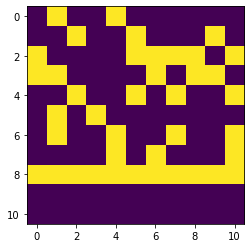

In [49]:
import matplotlib.pyplot as plt
plt.imshow(obs[ind][0])

In [50]:
edging_temp = np.pad(obs[ind][0]+obs[ind][1], pad_width=1, mode='constant', constant_values=0) #custom_concat_matrix(ind, i[1])


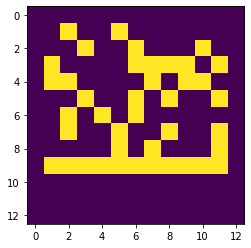

In [51]:
plt.imshow(edging_temp)

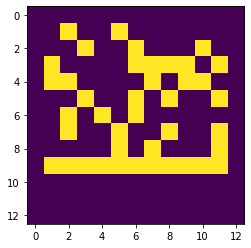

In [52]:
G = nx.grid_graph(edging_temp.shape)
           
x, y = np.where(edging_temp ==1) 
for i, j in zip(x,y):
    if (i,j) != (6,6) and (i,j) != (0,12):
        # try:
        G.remove_node((i,j))
        # except:...
                 
     
plt.imshow(edging_temp)                  

In [53]:
nx.astar_path(G, (6,6), (0,12))


[(6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (5, 12),
 (4, 12),
 (3, 12),
 (2, 12),
 (1, 12),
 (0, 12)]

In [54]:
path = np.array(nx.astar_path(G, (6,6), (0,12))[1]) - (6,6)
steps = {
    0: (0, 0),
    2: (1, 0),   
    1: (-1, 0),  
    4: (0, 1),   
    3: (0, -1),  
}
                  
[k for k in steps if (steps[k] == path).all()]
            

[4]

In [55]:
solver.bot_8_path[-1]

IndexError: list index out of range

In [59]:
np.array([1,2])*[False,False]

array([0, 0])

In [92]:
import numpy as np


class History(object):

    def __init__(self, obstacles):
        self.maps = []
        for obs in obstacles:
            self.maps.append(obs)
        self.relative_pos = np.zeros((len(obstacles), 2), dtype=np.int32)   # сдвиг агента относительно стартовой точки
        self.curr_pos = np.ones((len(obstacles), 2), dtype=np.int32) * 5    # текущее положение агента в map
        self.edges = np.zeros((len(obstacles), 4), dtype=np.int32)          # Пределы куда доходили вгенты на своих картах
                                                                            # [min_up, max_down, min_left, max_right]
        self.steps = {0: (0, 0),   # stay
                      1: (-1, 0),  # up
                      2: (1, 0),   # down
                      3: (0, -1),  # left
                      4: (0, 1)}   # right
        self.prev_obstacles = None
        self.prev_actions = None

    def update_history(self, obstacles, actions):
        if self.prev_actions is not None:
            mask = np.array([np.array_equiv(self.prev_obstacles[i], obstacles[i]) for i in range(len(obstacles))])[...,None]
            self.prev_actions *= mask

            # обновляем позиции относительно старта и текущие позиции на карте
            self.relative_pos += self.prev_actions
            self.curr_pos += self.prev_actions

            for bot, obs in enumerate(obstacles):
                min_up, max_down, min_left, max_right = self.edges[bot]

                # проверяеям выход за верхний предел для агента
                if self.relative_pos[bot, 0] < min_up:
                    new_line = np.empty((1, self.maps[bot].shape[1]))
                    new_line[:] = 1 #np.NaN
                    self.maps[bot] = np.concatenate((new_line, self.maps[bot]), axis=0)
                    min_up = self.relative_pos[bot, 0]
                    self.curr_pos[bot, 0] += 1

                # проверяеям выход за нижний предел для агента
                elif self.relative_pos[bot, 0] > max_down:
                    new_line = np.empty((1, self.maps[bot].shape[1]))
                    new_line[:] = 1 #np.NaN
                    self.maps[bot] = np.concatenate((self.maps[bot], new_line), axis=0)
                    max_down = self.relative_pos[bot, 0]

                # проверяеям выход за левый предел для агента
                if self.relative_pos[bot, 1] < min_left:
                    new_col = np.empty((self.maps[bot].shape[0], 1))
                    new_col[:] = 1 #np.NaN
                    self.maps[bot] = np.concatenate((new_col, self.maps[bot]), axis=1)
                    min_left = self.relative_pos[bot, 1]
                    self.curr_pos[bot, 1] += 1

                # проверяеям выход за правый предел для агента
                elif self.relative_pos[bot, 1] > max_right:
                    new_col = np.empty((self.maps[bot].shape[0], 1))
                    new_col[:] = 1 #np.NaN
                    self.maps[bot] = np.concatenate((self.maps[bot], new_col), axis=1)
                    max_right = self.relative_pos[bot, 1]

                # обновляем пределы для агента
                self.edges[bot] = np.array((min_up, max_down, min_left, max_right))

                # обновляем карту агента
                x, y = self.curr_pos[bot]
                self.maps[bot][x-5:x+6, y-5:y+6] = obs
        self.prev_obstacles = obstacles
        self.prev_actions = np.array(list(map(lambda x: self.steps[x], actions)))


if __name__ == '__main__':
    obstacles1 = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1],
                           [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
                           [1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1],
                           [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1],
                           [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1],
                           [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1],
                           [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
                           [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
                           [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],
                           [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
                           [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]], dtype=np.float64)
    obstacles2 = np.array([[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
                           [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
                           [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
                           [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
                           [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
                           [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1],
                           [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
                           [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
                           [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
                           [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                           [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]], dtype=np.float64)
    res = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
                    [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
                    [1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
                    [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
                    [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
                    [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1],
                    [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
                    [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
                    [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
                    [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]], dtype=np.float64)

    # h = History([obstacles1])
    # res_h = h.update_history([obstacles2], [4])
    # assert np.array_equal(res, res_h[0])


In [99]:

import networkx as nx
import gym
# from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
# from IPython.display import SVG, display
import numpy as np
# import pogema
from pogema import GridConfig
# import matplotlib.pyplot as plt


# from custom_networkx import astar_path, grid_graph
# from history import History

# 0. Cкладываем матрицы агентов и препядствий (они пересеаться не будут)
# 1. Добавляем рамку по краям
# 2. Получаем координаты старта финиша
# 3. Получаем следующий шаг от А*
# 4. повторили упражнение
# 5. Завтра добавлю персонального картографа)

class Model:
    def __init__(self, history=None):
        self.agents = None
        self.actions = {tuple(GridConfig().MOVES[i]): i for i in
                        range(len(GridConfig().MOVES))}  # make a dictionary to translate coordinates of actions into id
        
        self.history = history
        count_agents = len(self.history.maps) 
    
        self.steps = [[0 for i in range(count_agents)]] if self.history is not None else []
        # self.steps_corr = []
        self.errors = 0
        self.temp_pos = []
        self.temp_ed = []
        self.temp_a = []
        self.temp_b = []

    def act(self, obs, dones, positions_xy, targets_xy, ) -> list:
        self.temp_pos.append(obs)

        # Достаем предыдущий шаг

        if self.history is not None:
            steps = self.steps[-1]  
            
            self.history.update_history([i[0] for i in obs], steps)

        
        def custom_concat_matrix(iter_, agents_one):
             # обновляем карту агента
            x, y  = self.history.curr_pos[iter_]
            # print(x, y)
            temp_maps = self.history.maps[iter_].copy()
            temp_maps[x-5:x+6, y-5:y+6] += agents_one
            # print(temp_maps.shape)
            return temp_maps

        def veiw_shot_list(res, x, y):
            x, y = np.where(res[x-1:y+2,x-1:y+2] == 0)
            path = np.array([(i,j) for i, j in zip(x, y)]) - (1,1)
            steps = {
                    0: (0, 0),
                    2: (1, 0),   
                    1: (-1, 0),  
                    4: (0, 1),   
                    3: (0, -1),  
                }
            x_ = [[k for k in steps if (steps[k] == i).all()] for i in path]
            return [i for j in x_ for i in j]

        

        # Подготавливаем расширенную матрицу с окантовкой и смещенными точками старта\финиша
        a_ = []
        b_ = []
        edging_ = []
        for ind, i in enumerate(obs):
            pos_i_temp, pos_j_temp = np.where(i[2] == 1)
            # a_temp = (int(i.shape[1]/2)+1,int(i.shape[1]/2)+1)

            # if not 0 in [z for z in i[0][...,0]]:
            #     edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0)[...,2:]
            #     a_temp = (a_temp[0], a_temp[1]-2)

            # elif not 0 in [z for z in i[0][...,-1]]:
            #     edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0)[...,:-2]

            # elif not 0 in [z for z in i[0][0,]]:
            #     edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0)[2:]
            #     a_temp = (a_temp[0]-2, a_temp[1])

            # elif not 0 in [z for z in i[0][-1,]]:
            #     edging_temp = np.pad(i[0]+i[1], pad_width=1, mode='constant', constant_values=0)[:-2]

            # else:
            edging_temp = np.pad(custom_concat_matrix(ind, i[1]), pad_width=1, mode='constant', constant_values=0) #custom_concat_matrix(ind, i[1])   i[0]+i[1]
            edging_.append(edging_temp)
            # a_.append(a_temp)
            x, y  = self.history.curr_pos[ind]
            a_.append((x+1,y+1))

            b_.append((x-5+pos_i_temp[0], y-5+pos_j_temp[0]))

    
        # основной код - генерим граф делаем поиск А*
        k = 0
        next_step = []
        self.temp_ed.append(edging_)
        self.temp_a.append(a_)
        self.temp_b.append(b_)
        for edging, a, b in zip(edging_, a_, b_):
            G = nx.grid_graph(edging.shape)
            # G = grid_graph(edging.shape)
            x, y = np.where(edging ==1) 
            for i, j in zip(x,y):
                if (i,j) != a and (i,j) != b:
                    try:
                        G.remove_node((i,j))
                    except:...
                        # print('error', i, j)

            if edging[a[0],a[1]] == 1:
                try:
                    path = np.array(nx.astar_path(G, a, b)[1]) - a
                    steps = {
                        0: (0, 0),
                        2: (1, 0),   
                        1: (-1, 0),  
                        4: (0, 1),   
                        3: (0, -1),  
                    }
                    # nx.draw(G,)
                    next_step.append([k for k in steps if (steps[k] == path).all()][0])
                except:
                    self.errors +=1
                    
                    # исправить на действие доступное в области видимости
                    print('AAAAAAuhhh    a = ', a)
                    true_step = veiw_shot_list(obs[k][0]+obs[k][1], 5,5)
                    # v = [1 for i in range(len(true_step))]
                    # v_ = np.exp(v)/np.sum(np.exp(v))
                    next_step.append(np.random.choice(true_step)) 
            else:
                next_step.append(0)
            k+=1

        # проверка на пропуск хода
        for ind, i in enumerate([i[1] for i in obs]):
            if (i[4,4] == 1 or i[5,6] == 1 or i[4,5] == 1 or i[4,6] == 1 or i[6,6] == 1) and  i[5,5] == 1:
                print('стоим на месте')
                next_step[ind] = 0
                path = (0,0)

        # Проверка на зацикленность
        try:
            # по агентам
            for ind, i in enumerate(range(len(obs))):
                history_path = [j[i] for j in self.steps[-4:]]
                x_ = np.unique(history_path[::2])
                x_1 = np.unique(history_path[1::2])
                if len(x_) == 1  and len(x_1) == 1:
                    print('Врубаем жесткий рандом!!!!!')
                    temp_step = next_step[ind]
                    true_step = veiw_shot_list(edging, 5, 5)
                    true_step.pop(temp_step)
                    v = [1 for i in range(len(true_step))]
                    try:
                        ind_1 = true_step.index(x_)
                        v[ind_1] = v[ind_1]/2
                    except:...
                    try:
                        ind_2 =  true_step.index(x_)
                        v[ind_2] = v[ind_2]/2
                    except:...
                    try:
                        ind_3 = true_step.index(0)
                        v[ind_3] = v[ind_3]/2
                    except:...
                    v_ = np.exp(v)/np.sum(np.exp(v))
                    next_step[ind] = np.random.choice(true_step, p=v_)
        except:...
        # Сохраняем текущий шаг
        self.steps.append(next_step)
        # self.steps_corr.append(path)

        return next_step


# def main():
# Define random configuration
grid_config = GridConfig(num_agents=32,  # количество агентов на карте
                            size=64,  # размеры карты
                            density=0.3,  # плотность препятствий
                            seed=6,  # сид генерации задания
                            max_episode_steps=256,  # максимальная длина эпизода
                            obs_radius=5,  # радиус обзора
                            )
from pogema.wrappers.metrics import MetricsWrapper
env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)
env = MetricsWrapper(env)
obs = env.reset()

done = [False for k in range(len(obs))]
history = History([i[0] for i in obs])
solver = Model(history) 

while not all(done):
    # Используем AStar
    obs, reward, done, info = env.step(solver.act(obs, done,
                                                    env.get_agents_xy_relative(),
                                                    env.get_targets_xy_relative()),
                                                    )                                           


# сохраняем анимацию и рисуем ее
env.save_animation("render_1.svg", egocentric_idx=None)
CSR = info[0]['metrics'].get('CSR')
ISR = np.mean([x['metrics'].get('ISR',0) for x in info])
print('CSR = ', CSR, 'ISR = ',  ISR,'\n')
print(f'errors = {solver.errors}')

print(env.get_agents_xy())

# if __name__ == '__main__':
#     main()

AAAAAAuhhh    a =  (6, 6)
стоим на месте
стоим на месте
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
AAAAAAuhhh    a =  (6, 6)
AAAAAAuhhh    a =  (6, 6)
стоим на месте
стоим на месте
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
стоим на месте
стоим на месте
стоим на месте
стоим на месте
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
Врубаем жесткий рандом!!!!!
AAAAAAuhhh    a =  (6, 6)
AAAA

In [101]:
ind = 3

print(solver.temp_pos[-1][ind])
print(solver.temp_ed[-1][ind])
print(solver.temp_a[-1][ind])
print(solver.temp_b[-1][ind])

[[[0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
  [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.]
  [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

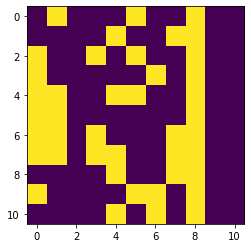

In [72]:
plt.imshow(solver.temp_pos[-1][ind][0])

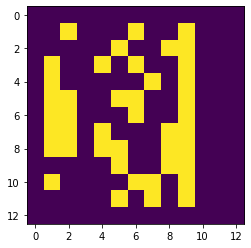

In [73]:
plt.imshow(solver.temp_ed[-1][ind])

In [82]:
G = nx.grid_graph(solver.temp_ed[-1][ind].shape)
# G = grid_graph(edging.shape)
x, y = np.where(solver.temp_ed[-1][ind] ==1) 
for i, j in zip(x,y):
    if (i,j) != solver.temp_a[-1][ind] and (i,j) != solver.temp_b[-1][ind]:
        # try:
        G.remove_node((i,j))
        # except:...
            # print('error', i, j)

if solver.temp_ed[-1][ind][solver.temp_a[-1][ind][0],solver.temp_a[-1][ind][1]] == 1:
    xxx = nx.astar_path(G, solver.temp_a[-1][ind], solver.temp_b[-1][ind])
    
xxx

[(6, 6),
 (6, 7),
 (7, 7),
 (8, 7),
 (9, 7),
 (9, 8),
 (10, 8),
 (11, 8),
 (12, 8),
 (12, 9),
 (12, 10),
 (11, 10),
 (10, 10),
 (9, 10),
 (8, 10),
 (7, 10),
 (6, 10),
 (5, 10),
 (4, 10),
 (3, 10),
 (2, 10),
 (1, 10),
 (1, 11)]

In [88]:
path = np.array(xxx[1]) - solver.temp_a[-1][ind]
steps = {
    0: (0, 0),
    2: (1, 0),   
    1: (-1, 0),  
    4: (0, 1),   
    3: (0, -1),  
}
[k for k in steps if (steps[k] == path).all()]

[4]